# INST728E - Module 8. Sentiment Analysis

A common task in social media analytics is sentiment analysis, where we measure how positive or negative a message is by its text. Note that we often omit emoji despite their potential utility. Recent research is working to integrate that information.

For now though, we'll look into sentiment towards our event over time.

For that, we'll use the temporal methods from Module 5 and introduce some new packages for sentiment.

In [1]:
%matplotlib inline

import datetime
import json

import numpy as np

# For plotting
import matplotlib.pyplot as plt

# NLTK's sentiment code
import nltk
import nltk.sentiment.util
import nltk.sentiment.vader

# TextBlob provides its own sentiment analysis
from textblob import TextBlob

## Carry Forward Disaster Data

In [2]:
crisisInfo = {
    "Women's March": {
        "name": "Women's March 2017",
        "time": 1484992800, # 21 January 2017, 6:58 UTC to 08:11 UTC
        "directory": "womensmarch",    # Where do we find the relevant files
        "keywords": [    # How can we describe this event?
            "women's march","resist", "notmypresident","inauguration","women's right","human right","planned parenthood"
        ],
        "place": [
            38.899539,# Latitude
            -77.036551 # Longitude
        ],
        "box": {    # Where did this event occur?
            "lowerLeftLon": -77.119759,
            "lowerLeftLat": 38.791645,
            "upperRightLon": -76.909393,
            "upperRightLat": 38.995548,
        }
    },
}

In [3]:
# Replace the name below with your selected crisis
selectedCrisis = "Women's March"


<hr>

## Reading Relevant Tweets

Re-read our relevant tweets...

In [4]:

in_file_path = "/Users/yutingliao/Desktop/INST728 E/relevant_tweet_output_keywords_updated.json" # Replace this as necessary

relevant_tweets = []
with open(in_file_path, "r") as in_file:
    for line in in_file:
        relevant_tweets.append(json.loads(line.encode("utf8")))
        
print("Relevant Tweets:", len(relevant_tweets))

Relevant Tweets: 4447


### Temporal Ordering

In [66]:
# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

# Frequency map for tweet-times
rel_frequency_map = {}
for tweet in relevant_tweets:
    # Parse time
    currentTime = datetime.datetime.strptime(tweet['created_at'], timeFormat)

    # Flatten this tweet's time
    currentTime = currentTime.replace(second=0, minute = 0)

    # If our frequency map already has this time, use it, otherwise add
    extended_list = rel_frequency_map.get(currentTime, [])
    extended_list.append(tweet)
    rel_frequency_map[currentTime] = extended_list
    
# Fill in any gaps
times = sorted(rel_frequency_map.keys())
print (len(times))
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):

    rel_frequency_map[thisTime] = rel_frequency_map.get(thisTime, [])
        
    thisTime = thisTime + timeIntervalStep

# Count the number of minutes
print ("Start Time:", firstTime)
print ("Stop Time:", lastTime)
print ("Processed Times:", len(rel_frequency_map))


86
Start Time: 2017-01-21 10:00:00
Stop Time: 2017-01-24 23:00:00
Processed Times: 5101


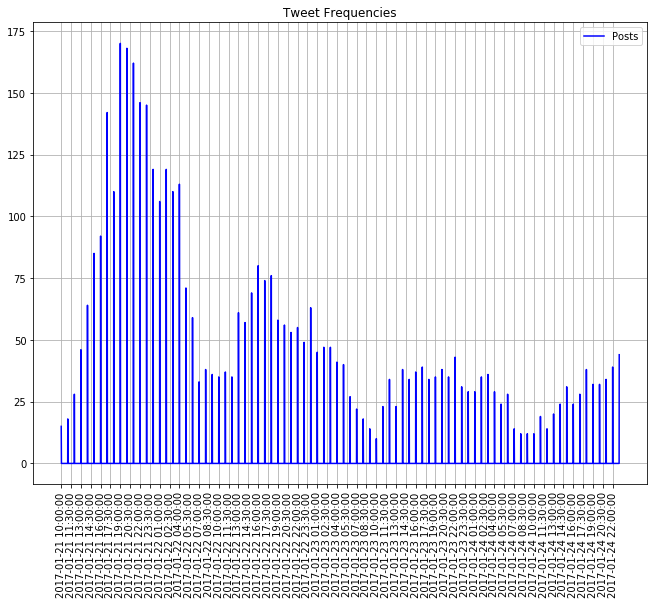

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequencies")

sortedTimes = sorted(rel_frequency_map.keys())
postFreqList = [len(rel_frequency_map[x]) for x in sortedTimes]

smallerXTicks = range(0, len(sortedTimes), 90)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

ax.plot(xData, postFreqList, color="blue", label="Posts")

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

---
## Content and Sentiment Analysis

"Sentiment analysis" is used to figure out how people **feel** about a specific topic.
Some tools also provide measurements like subjectivity/objectivity of text content.

We'll cover:

- Topically Relevant Filtering
- Sentiment, Subjectivity, and Objectivity

### Sentiment Analysis w/ TextBlob

TextBlob is a nice Python package that provides a number of useful text processing capabilities.
We will use it for sentiment analysis to calculate polarity and subjectivity for each relevant tweet.

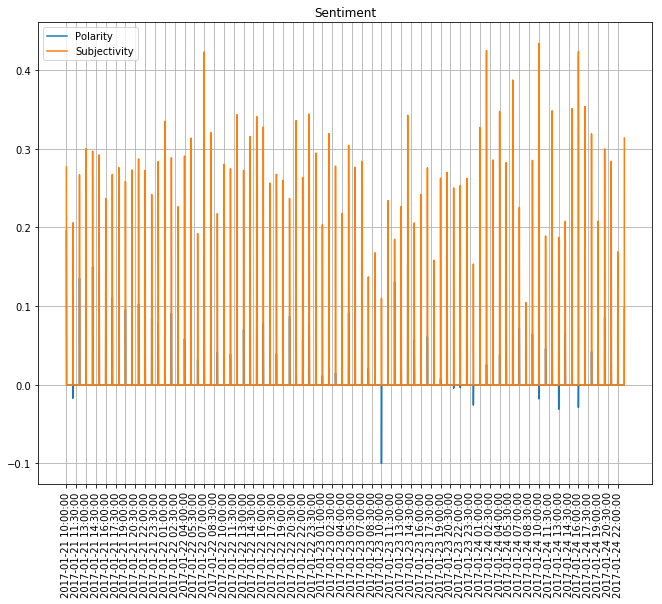

In [68]:
# Sentiment values
polarVals_tb = []
objVals = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    tweets = rel_frequency_map[t]
    
    # For calculating averages
    localPolarVals = []
    localObjVals = []
    
    for tweet in tweets:
        tweetString = tweet["text"]

        blob = TextBlob(tweetString)
        polarity = blob.sentiment.polarity
        objectivity = blob.sentiment.subjectivity
        
        localPolarVals.append(polarity)
        localObjVals.append(objectivity)
        
    # Add data to the polarity and objectivity measure arrays
    if ( len(tweets) > 0 ):
        polarVals_tb.append(np.mean(localPolarVals))
        objVals.append(np.mean(localObjVals))
    else:
        polarVals_tb.append(0.0)
        objVals.append(0.0)

        
# Now plot this sentiment data
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Sentiment")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

# Polarity is scaled [-1, 1], for negative and positive polarity
ax.plot(xData, polarVals_tb, label="Polarity")

# Subjetivity is scaled [0, 1], with 0 = objective, 1 = subjective
ax.plot(xData, objVals, label="Subjectivity")

ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

## Sentiment Analysis with Vader

In [69]:
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()

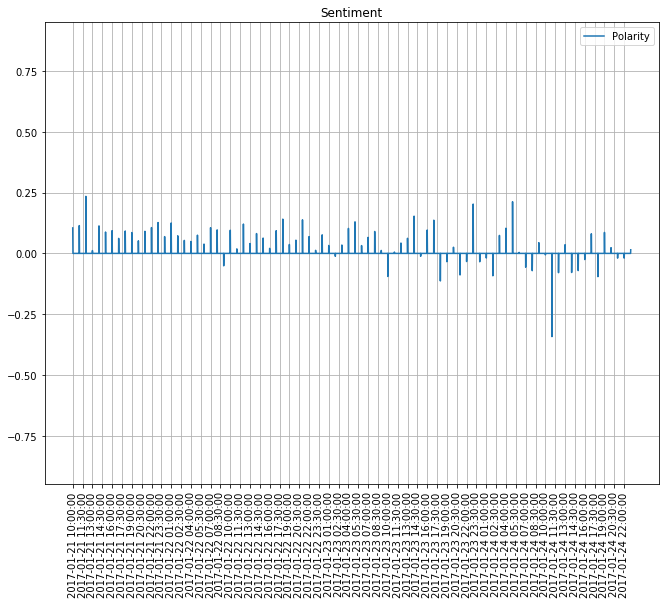

In [70]:
# Sentiment values
polarVals_vader = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    tweets = rel_frequency_map[t]
    
    # For calculating averages
    localPolarVals = []
    
    for tweet in tweets:
        tweetString = tweet["text"]

        polarity = vader.polarity_scores(tweetString)["compound"]
        
        localPolarVals.append(polarity)
        
    # Add data to the polarity and objectivity measure arrays
    if ( len(tweets) > 0 ):
        polarVals_vader.append(np.mean(localPolarVals))
    else:
        polarVals_vader.append(0.0)

        
# Now plot this sentiment data
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Sentiment")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

# Polarity is scaled [-1, 1], for negative and positive polarity
ax.plot(xData, polarVals_vader, label="Polarity")

ax.legend()
ax.grid(b=True, which=u'major')

plt.ylim((-0.95, 0.95))
plt.show()

### Vader vs. TextBlob

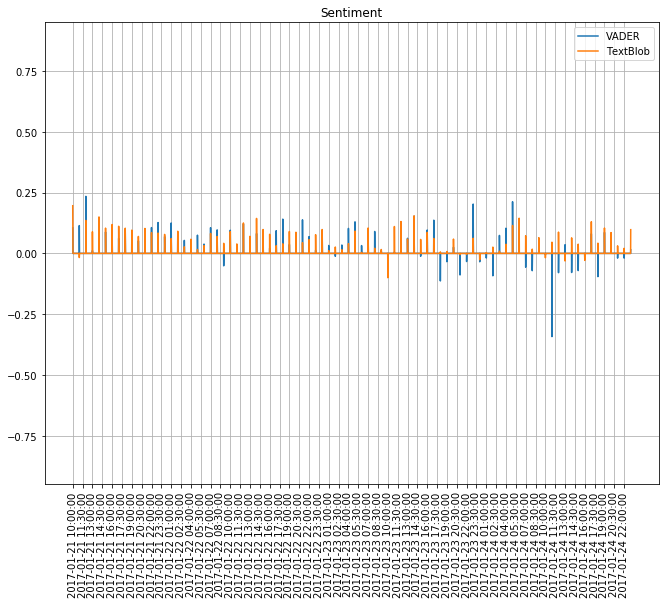

In [71]:
# Now plot this sentiment data
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Sentiment")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

# Polarity is scaled [-1, 1], for negative and positive polarity
ax.plot(xData, polarVals_vader, label="VADER")
ax.plot(xData, polarVals_tb, label="TextBlob")

ax.legend()
ax.grid(b=True, which=u'major')

plt.ylim((-0.95, 0.95))
plt.show()

## Sentiment Extremes

While sentiment analysis may seem a little silly given our focus on disaster, for some types of events, content that is especially negative or positive is interesting. 

For example, who might be posting extremely positive tweets in the wake of a terrorist attack?

To this end, let us use VADER to find the __top 5__ most positive and negative tweets in our dataset.

In [72]:
top_k = 10

In [73]:
# Calculate sentiment for each relevant tweet
sentiment_pairs = [(tweet, vader.polarity_scores(tweet["text"])["compound"]) 
                   for tweet in relevant_tweets]

sorted_tweets = sorted(sentiment_pairs, key=lambda x: x[1])

In [74]:
# Most negative tweets
for tweet, sentiment in sorted_tweets[:top_k]:
    print("Author:", tweet["user"]["screen_name"], "Sentiment:", sentiment)
    print("Text:\n%s" % tweet["text"], "\n")

Author: PZankl Sentiment: -0.9477
Text:
RT @rtraister: No reason to do this except a fear of the growing resistance to this cruel, unjust, racist, sexist law.  https://t.co/sP4oHL… 

Author: d3d0c3d Sentiment: -0.9231
Text:
@mehreenkasana @Anony_Mia keep spreading your message of hatred violating basic human rights, that moment in time he posed no threat. #wtf 

Author: warpony2310 Sentiment: -0.9201
Text:
Joe's Crime Blog/Human Right's Site: Two Suspect Terrorists Commit Suicide after Shootout in Saudi Arabia... https://t.co/oR8H6GRCLz 

Author: 3than_A Sentiment: -0.9118
Text:
RT @CurveResistant: Nah no way, my wife better let us all die. The kids, us, the dog, and the neighbors fuck you mean this bitch is a h…  

Author: iconcIit Sentiment: -0.9106
Text:
She's marching for women's rights and you decide to comment on what she's wearing. Fucking stupid ass bitch. https://t.co/wjSjA1xDcB 

Author: Guardian_Elite Sentiment: -0.9096
Text:
RT @Notmanipulated7: #ResistFromDay1 bc nothing t

In [75]:
# Most negative tweets
for tweet, sentiment in sorted_tweets[-top_k:]:
    print("Author:", tweet["user"]["screen_name"], "Sentiment:", sentiment)
    print("Text:\n%s" % tweet["text"], "\n")

Author: hackerkween Sentiment: 0.9217
Text:
RT @machinegunkelly: I'm super proud of my all my friends walking in the women's march today. also proud of whoever punched Richard Spencer… 

Author: RedXPower Sentiment: 0.9217
Text:
RT @varadmehta: "Resistance," on the other hand, is noble, heroic. It resounds of brave, self-sacrificing Frenchmen standing against the Na… 

Author: Colodemvoter Sentiment: 0.9274
Text:
@elizabethforma @SharpShooterSev -"A woman's place is in the Resistance" -great updated slogan. Truly hope that SecClinton is happy 
today. 

Author: h0700k_23 Sentiment: 0.9274
Text:
RT @rosandraafierro: Love is love. Black lives matter. Climate change is real. Immigrants make American great. Women's rights are Human…  

Author: crackleackles Sentiment: 0.9274
Text:
RT @samtruglio: "Love is love. Black lives matter. Immigrants make America great. Climate change is real. Women's rights are human rights" 

Author: Christi21689609 Sentiment: 0.9515
Text:
RT @MarkRuffalo: Thank y

## Compared to TextBlob

In [76]:
# Calculate sentiment for each relevant tweet
sentiment_pairs = [(tweet, TextBlob(tweet["text"]).sentiment.polarity) 
                   for tweet in relevant_tweets]

sorted_tweets = sorted(sentiment_pairs, key=lambda x: x[1])

print("Most Negative Tweets:")
# Most negative tweets
for tweet, sentiment in sorted_tweets[:top_k]:
    print("Author:", tweet["user"]["screen_name"], "Sentiment:", sentiment)
    print("Text:\n%s" % tweet["text"], "\n")
    
print("------------------------")
print("Most Positive Tweets:")
# Most positive tweets
for tweet, sentiment in sorted_tweets[-top_k:]:
    print("Author:", tweet["user"]["screen_name"], "Sentiment:", sentiment)
    print("Text:\n%s" % tweet["text"], "\n")

Most Negative Tweets:
Author: MellieMel57 Sentiment: -1.0
Text:
Canadians traveling to Women's March denied US entry after sharing plans https://t.co/k58k0A2h2f  The Northern Wall is Up Disgusting 

Author: AdsGriffs Sentiment: -1.0
Text:
@ReliableSources get some fucking people of color on there!!!!!! It's 2017, the women's march was yesterday, GET IT TOGETHER. 

Author: DanielaMontiel Sentiment: -1.0
Text:
RT @MRodOfficial: https://t.co/7lAMXqmZ6J women's march Ashley Judd speech. I'm a nasty women too I stand with all you gals to the death, A… 

Author: isleswithsnow Sentiment: -1.0
Text:
RT @GOPBlackChick: Women's March=bunch of nasty liberal women. https://t.co/gE7uGiq71W 

Author: OnyianiE Sentiment: -1.0
Text:
RT @newslaves2016: Absolutely HORRIBLE. Biafrans celebrating trump are massacred!!! 

#MAGA #inauguration #protest #resistance…  

Author: Yes_WeThePeople Sentiment: -1.0
Text:
#ResistTrumpTuesdays  Filthy liberals--get a job and go to work instead of mooching on the taxpa